In [1]:
import pandas as pd
import os, sys, pandas, pathlib, time
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm, trange
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import random

Image.MAX_IMAGE_PIXELS = None #Throws error if size of images exceeds this number

In [2]:
#Creates dictionary mapping labels(string) to vector(one-hot encoding)
all_labels = list(np.load('materials/UBC-OCEAN_CS640/all_labels.npy'))
num_classes = len(all_labels)
label_dict = defaultdict(lambda: torch.zeros(num_classes))
for i, label in enumerate(all_labels):
    label_dict[label][i] = 1

In [3]:
    # change the size only if necessary
transform = v2.Compose([v2.Resize(512, antialias = True),
                            v2.CenterCrop(448),
                            v2.ToImage(),
                            v2.ToDtype(torch.float32, scale = True),
                            v2.Normalize(mean = [0.4887, 0.4266, 0.4855], std = [0.4212, 0.3790, 0.4169])])

In [4]:
## TODO: create list of transformed images and update dataset class removing transforms

def load_transform_images(folder_path):
    images = {}  # Dictionary to store transformed images

    for filename in tqdm(os.listdir(folder_path)):
        if filename.endswith('.jpg'):  # Check for .jpg files
            img_name = os.path.splitext(filename)[0]  # Extract the name (assuming it's a number)
            #print(img_name)
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert image to RGB (if not already)
                transformed_img = transform(img)  # Apply the transformation
                images[img_name] = transformed_img  # Store in dictionary with name as key

    return images

# Example usage
folder_path = 'materials/UBC-OCEAN_CS640/train_images_compressed_80/'
transformed_images = load_transform_images(folder_path)

100%|██████████| 430/430 [19:05<00:00,  2.66s/it]


In [5]:
## Create list of training images and validation images using a split
def split_dataset(images, train_ratio=0.8):
    total_images = len(images)
    train_size = int(total_images * train_ratio)

    # Randomly shuffle the images
    shuffled_items = list(images.items())
    random.shuffle(shuffled_items)

    # Split the images into training and validation sets
    train_images = dict(shuffled_items[:train_size])
    validation_images = dict(shuffled_items[train_size:])

    return train_images, validation_images

train_images, validation_images = split_dataset(transformed_images)


print(f'Number of training images: {len(train_images.keys())}')
print(f'Number of validation images: {len(validation_images.keys())}')
print(f'Type of key: {type(list(train_images.keys())[0])}')
print(f'Type of image: {type(list(train_images.values())[0])}')
print(f'Size of image: {list(train_images.values())[0].size()}')

Number of training images: 344
Number of validation images: 86
Type of key: <class 'str'>
Type of image: <class 'torchvision.tv_tensors._image.Image'>
Size of image: torch.Size([3, 448, 448])


In [6]:
##TODO: Update dataset to pass in list of images
class CustomDataset(Dataset):
    def __init__(self, csv_file, images, num_classes):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            num_classes (int): Total number of classes.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)

        self.name_to_id = self.labels_frame['image_id'].to_dict()
        self.id_to_name = {int(v):k for k, v in self.name_to_id.items()}
        
        
        self.images = images
        self.image_names = list(self.images.keys())  # List of image names
        self.num_classes = num_classes

    def __len__(self):
        return len(list(self.images.keys()))

    def __getitem__(self, idx):
        image = self.images[self.image_names[idx]]

        label = self.labels_frame.iloc[self.id_to_name[int(self.image_names[idx])], 1]
        #print(self.labels_frame.iloc[self.id_to_name[int(self.image_names[idx])]])
        # Convert label to one-hot encoding
        one_hot = label_dict[str(label)]
        return image, one_hot

In [7]:
## TODO: Add validation set and update method calls
batch_size = 8

# Create the dataset
train_dataset = CustomDataset(csv_file='materials/UBC-OCEAN_CS640/train.csv', images=train_images, num_classes=num_classes)
validation_dataset = CustomDataset(csv_file='materials/UBC-OCEAN_CS640/train.csv', images=validation_images, num_classes=num_classes)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

# Now you can use this dataloader in your training loop

In [8]:
#Size of the reshaped first image in the data set
#(RGB * width * height)
print(f'Numer of training examples: {train_dataset.__len__()}')
print(f'Numer of testing examples: {validation_dataset.__len__()}')
print(f'Type of pairing: {type(train_dataset.__getitem__(0))}')
print(f'Number of inputs + outputs: {len(validation_dataset.__getitem__(0))}')
print(f'Size of input: {train_dataset.__getitem__(0)[0].size()}')
print(f'First input(normalized): {train_dataset.__getitem__(0)[0]}')
print(f'First output(one-hot encoding): {train_dataset.__getitem__(0)[1]}')

Numer of training examples: 344
Numer of testing examples: 86
Type of pairing: <class 'tuple'>
Number of inputs + outputs: 2
Size of input: torch.Size([3, 448, 448])
First input(normalized): Image([[[-1.1603, -1.1603, -1.1603,  ...,  0.6925,  0.7205,  0.7484],
        [-1.1603, -1.1603, -1.1603,  ...,  0.7298,  0.7670,  0.7484],
        [-1.1603, -1.1603, -1.1603,  ...,  0.7484,  0.7670,  0.7577],
        ...,
        [ 0.7763,  0.7856,  0.8136,  ..., -1.1603, -1.1603, -1.1603],
        [ 0.8136,  0.8043,  0.8136,  ..., -1.1603, -1.1603, -1.1603],
        [ 0.8694,  0.8508,  0.7949,  ..., -1.1603, -1.1603, -1.1603]],

       [[-1.1256, -1.1256, -1.1256,  ...,  0.4679,  0.5093,  0.5713],
        [-1.1256, -1.1256, -1.1256,  ...,  0.5093,  0.5610,  0.5403],
        [-1.1256, -1.1256, -1.1256,  ...,  0.5403,  0.5713,  0.5713],
        ...,
        [ 0.6645,  0.6852,  0.7472,  ..., -1.1256, -1.1256, -1.1256],
        [ 0.7783,  0.7265,  0.7576,  ..., -1.1256, -1.1256, -1.1256],
        [ 0

In [9]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [10]:
class CancerCNN(nn.Module):
    def __init__(self):
        super(CancerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)

        self.dropout = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(1024 * 14 * 14, 2048) 
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 5)  

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through the conv layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))

        x = x.view(-1, 1024 * 14 * 14) 
        
        # Forward pass through the fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function here, it will be applied outside if needed (e.g., softmax)

        return x

In [11]:
torch.cuda.empty_cache()

In [12]:
# Step 4: Initialize the CNN Model
model = CancerCNN().float()
print(model)

model = model.to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

CancerCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=200704, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


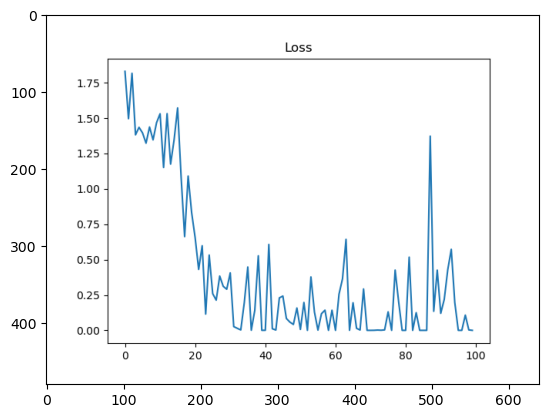

In [13]:
num_epochs = 100

losses = []


try:
    model = torch.load('Cancer_CNN_Final.pt')
    img = mpimg.imread('loss_Final.png')
    imgplot = plt.imshow(img)
    plt.show()
    
except:
    model.train()
    for epoch in tqdm(range(num_epochs)):  # Number of epochs
        for data, target in tqdm(train_dataloader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            #print(f'output: {output}')
            #print(f'target: {target.type_as(output)}\n')
            loss = criterion(output, target.type_as(output)) # Ensuring target is same type as output
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        #print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    torch.save(model, 'Cancer_CNN_Final.pt')

    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(losses)
    plt.title('Loss')
    plt.show()
    fig.savefig('loss_Final.png')

In [14]:
YPredict = []
YTrue = []

for data, target in tqdm(validation_dataloader):
    data = data.to(device)  
    output = model(data)
    pred = int(torch.argmax(output))
    label = int(torch.argmax(target))
    YPredict.append(pred)
    YTrue.append(label)
    
print("Confusion matrix: " + str(confusion_matrix(YTrue, YPredict)))
print("Accuracy: " + str(accuracy_score(YTrue, YPredict)))
print("F1: " + str(f1_score(YTrue, YPredict, average = "macro")))

100%|██████████| 86/86 [00:01<00:00, 72.17it/s]

Confusion matrix: [[32  1  0  1  1]
 [ 2 17  1  0  0]
 [ 0  0  9  0  0]
 [ 6  0  0  8  0]
 [ 3  1  0  0  4]]
Accuracy: 0.813953488372093
F1: 0.7901425805315966
